In [1]:
import qutip as qp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Hamiltonian

In [163]:
class Hamiltonian:
    def __init__(self, N, kappa, theta, rho, Phi):
        """
        N: Number of neutrinos
        kappa: Relative strength of one body energy divided by the number of neutrinos
        theta: Mixing angle
        rho: Electron relative density
        Phi: Propagation angle matrix, Phi[i,j] for i<j is the propagation angle between neutrinos i and j.
        """
        assert Phi.shape == (N,N)
        self.N = N
        self.kappa = kappa
        self.theta = theta
        self.rho = rho
        self.Phi = Phi
        self.b1 = self.kappa * np.sin(2*self.theta)
        self.b2 = 0
        self.b3 = self.rho/2 - self.kappa * np.cos(2*self.theta)

    def pauliX(i,N):
        return qp.tensor([qp.sigmax() if j == i else qp.identity(2) for j in range(N)])

    def pauliY(i,N):
        return qp.tensor([qp.sigmay() if j == i else qp.identity(2) for j in range(N)])
    
    def pauliZ(i,N):
        return qp.tensor([qp.sigmaz() if j == i else qp.identity(2) for j in range(N)])
        
    def toQObj(self):
        """Return Hamiltonian as qutip QObj"""        
        H = qp.tensor([0 * qp.identity(2) for i in range(self.N)]) # initialize H to zero matrix

        for i in range(self.N):
            X = Hamiltonian.pauliX(i, self.N)
            Y = Hamiltonian.pauliY(i, self.N)
            Z = Hamiltonian.pauliZ(i, self.N)
            H += self.b1*X + self.b2*Y + self.b3*Z
        
        for i in range(self.N):
            for j in range(i+1, self.N):
                phi = self.Phi[i,j]
                Xi = Hamiltonian.pauliX(i, self.N)
                Yi = Hamiltonian.pauliY(i, self.N)
                Zi = Hamiltonian.pauliZ(i, self.N)
                Xj = Hamiltonian.pauliX(j, self.N)
                Yj = Hamiltonian.pauliY(j, self.N)
                Zj = Hamiltonian.pauliZ(j, self.N)
                H += (1-np.cos(phi))/self.N * (Xi * Xj + Yi * Yj + Zi * Zj)

        return H

    def oneBodyQObj(self):
        """Return one-body Hamiltonian as qutip QObj"""        
        H = qp.tensor([0 * qp.identity(2) for i in range(self.N)]) # initialize H to zero matrix

        for i in range(self.N):
            X = Hamiltonian.pauliX(i, self.N)
            Y = Hamiltonian.pauliY(i, self.N)
            Z = Hamiltonian.pauliZ(i, self.N)
            H += self.b1*X + self.b2*Y + self.b3*Z
            
        return H

    def pairQObj(self, i, j):
        """Return Hamiltonian for neutrino i and j as qutip QObj"""
        assert i < j, "expect i < j"
        
        X0 = Hamiltonian.pauliX(i, self.N)
        Y0 = Hamiltonian.pauliY(i, self.N)
        Z0 = Hamiltonian.pauliZ(i, self.N)
        X1 = Hamiltonian.pauliX(j, self.N)
        Y1 = Hamiltonian.pauliY(j, self.N)
        Z1 = Hamiltonian.pauliZ(j, self.N)
        H = (self.b1 * (X0 + X1) + self.b2 * (Y0 + Y1) + self.b3 * (Z0 + Z1))/(self.N-1) + (1 - np.cos(self.Phi[i,j]))/self.N * (X0*X1+Y0*Y1+Z0*Z1)
        return H

    def interactionQObj(self, i, j):
        """Return the interaction term between neutrinos i and j as qutip QObj"""
        X0 = Hamiltonian.pauliX(i, self.N)
        Y0 = Hamiltonian.pauliY(i, self.N)
        Z0 = Hamiltonian.pauliZ(i, self.N)
        X1 = Hamiltonian.pauliX(j, self.N)
        Y1 = Hamiltonian.pauliY(j, self.N)
        Z1 = Hamiltonian.pauliZ(j, self.N)
    
        H = (1 - np.cos(self.Phi[i,j]))/self.N * (X0 * X1 + Y0 * Y1 + Z0 * Z1)
        return H

# Initial Conditions

In [195]:
N = 4
kappa = 1/N
theta = 0.195
rho = 0
Phi = np.arccos(0.9)/(N-1) * np.array([[abs(i-j) for i in range(N)] for j in range(N)])
Ham = Hamiltonian(N, kappa, theta, rho, Phi)

initial_flavors = [0,0,1,1]

t_start = 0
t_end = 30
steps = 300
shots = 5000

times = np.linspace(t_start, t_end, num=steps)

# Exact

In [156]:
def exact_evolution(t, Ham):
    H = Ham.toQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims)
    return U

# Single Trotter

In [147]:
def single_trotter_evolution(t, Ham):
    U = None
    for i in range(N):
        for j in range(i+1,N):
            H = Ham.pairQObj(i,j)
            if U is None:
                U = qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims)
            else:
                U = qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims) * U

    return U

# Double Trotter

In [ ]:
def double_trotter_evolution(t, Ham):
    H1 = Ham.oneBodyQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t*H1), dims = H1.dims)
    
    for i in range(N):
        for j in range(i+1,N):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t*H2), dims = H2.dims) * U

    return U

# Fractal

In [184]:
def fractal_evolution(t, Ham):
    U = None
    for i in range(N):
        for j in range(i+1,N):
            H = Ham.pairQObj(i,j)
            if U is None:
                U = qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
    
            elif not (i == N-2 and j == N-1):
             
                U = U * qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
            
    H = Ham.pairQObj(N-2, N-1)
    U = U * qp.Qobj(sp.linalg.expm(-1j*t*H), dims = H.dims)

    for i in reversed(range(N)):
        for j in reversed(range(i+1,N)):
            H = Ham.pairQObj(i,j)
            if U is None:
                U = qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
            elif not (i == N-2 and j == N-1):
                U = U * qp.Qobj(sp.linalg.expm(-0.5j*t*H), dims = H.dims)
    
    return U

# Double Fractal

In [205]:
def double_fractal_evolution(t, Ham):
    H1 = Ham.oneBodyQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t/2*H1), dims = H1.dims)
    
    for i in range(N):
        for j in range(i+1,N):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t/2*H2), dims = H2.dims) * U
            
    for i in reversed(range(N)):
        for j in reversed(range(i+1,N)):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t/2*H2), dims = H2.dims) * U

    U = qp.Qobj(sp.linalg.expm(-1j*t/2*H1), dims = H1.dims) * U
    return U

# Trotter Fractal

In [217]:
def trotter_fractal_evolution(t, Ham):
    H1 = Ham.oneBodyQObj()
    U = qp.Qobj(sp.linalg.expm(-1j*t/2*H1), dims = H1.dims)
    
    for i in range(N):
        for j in range(i+1,N):
            H2 = Ham.interactionQObj(i,j)
            U = qp.Qobj(sp.linalg.expm(-1j*t*H2), dims = H2.dims) * U

    U = qp.Qobj(sp.linalg.expm(-1j*t/2*H1), dims = H1.dims) * U
    
    return U

# Two steps Trotter

In [221]:
def two_steps_trotter_evolution(t, Ham):
    return double_trotter_evolution(t/2, Ham)**2

# Results

In [209]:
def inversion_probability(initial_flavors, U):
    initial_state = qp.tensor([qp.basis(2,i) for i in initial_flavors])
    #print(U.shape)
    final_state = U * initial_state
    dm = qp.ket2dm(final_state)
    probabilities = [dm.ptrace(i).diag()[1] if initial_flavors[i] == 0 else dm.ptrace(i).diag()[0] for i in range(len(initial_flavors))]
    return np.array(probabilities)

In [210]:
ts = np.linspace(t_start, t_end, steps)

## Exact

In [196]:
exact_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    exact_probabilities[:,idx] = inversion_probability(initial_flavors, exact_evolution(t, Ham))

## Single Trotter

In [197]:
single_trotter_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    single_trotter_probabilities[:,idx] = inversion_probability(initial_flavors, single_trotter_evolution(t, Ham))

## Double Trotter

In [198]:
double_trotter_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    double_trotter_probabilities[:,idx] = inversion_probability(initial_flavors, double_trotter_evolution(t, Ham))

## Fractal

In [199]:
fractal_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    fractal_probabilities[:,idx] = inversion_probability(initial_flavors, fractal_evolution(t, Ham))

## Double Fractal

In [206]:
double_fractal_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    double_fractal_probabilities[:,idx] = inversion_probability(initial_flavors, double_fractal_evolution(t, Ham))

## Two steps Trotter

In [222]:
two_steps_trotter_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    two_steps_trotter_probabilities[:,idx] = inversion_probability(initial_flavors, two_steps_trotter_evolution(t, Ham))

## Trotter Fractal

In [218]:
trotter_fractal_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    trotter_fractal_probabilities[:,idx] = inversion_probability(initial_flavors, trotter_fractal_evolution(t, Ham))

## Plots

C:\Users\wue09\AppData\Local\Temp\ipykernel_25504\3066472376.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts, np.log(np.abs(exact_probabilities[i] - single_trotter_probabilities[i])), label=f'Single Trotter Error', color='orange')
C:\Users\wue09\AppData\Local\Temp\ipykernel_25504\3066472376.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts, np.log(np.abs(exact_probabilities[i] - double_trotter_probabilities[i])), label=f'Double Trotter Error', color='g')
C:\Users\wue09\AppData\Local\Temp\ipykernel_25504\3066472376.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts, np.log(np.abs(exact_probabilities[i] - fractal_probabilities[i])), label=f'Single Fractal Error', color='r')
C:\Users\wue09\AppData\Local\Temp\ipykernel_25504\3066472376.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(ts, np.log(np.abs(exact_probabilities[i] - double_fractal_probabilities[i])), label=f'Double Fractal Error', color='y')
C:\Users\w

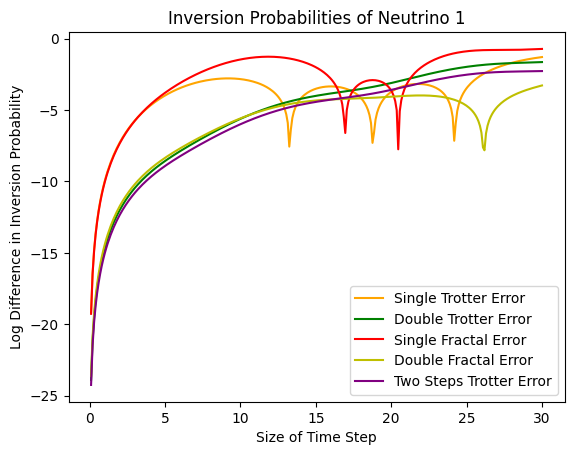

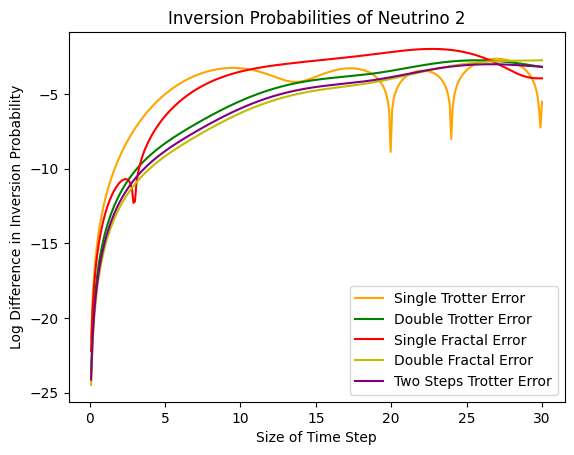

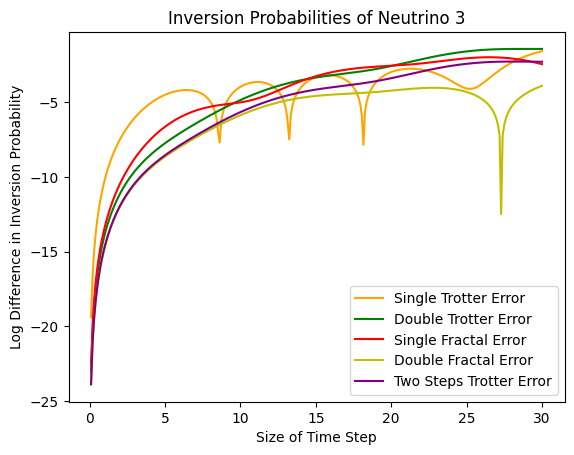

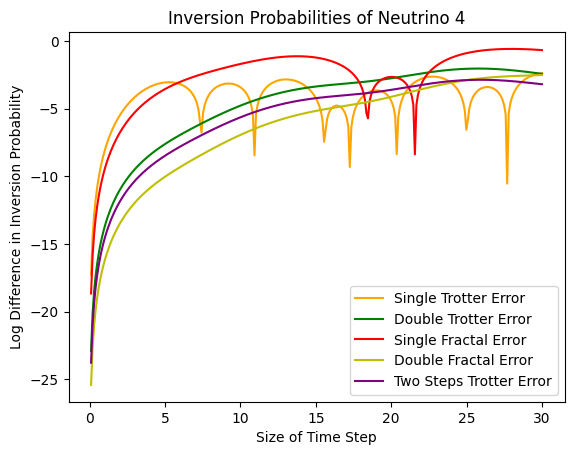

In [223]:
# Plot the probability curve for each qubit on the same graph
for i in range(N):
    plt.plot(ts, np.log(np.abs(exact_probabilities[i] - single_trotter_probabilities[i])), label=f'Single Trotter Error', color='orange')
    plt.plot(ts, np.log(np.abs(exact_probabilities[i] - double_trotter_probabilities[i])), label=f'Double Trotter Error', color='g')
    plt.plot(ts, np.log(np.abs(exact_probabilities[i] - fractal_probabilities[i])), label=f'Single Fractal Error', color='r')
    plt.plot(ts, np.log(np.abs(exact_probabilities[i] - double_fractal_probabilities[i])), label=f'Double Fractal Error', color='y')
    plt.plot(ts, np.log(np.abs(exact_probabilities[i] - two_steps_trotter_probabilities[i])), label=f'Two Steps Trotter Error', color='purple')
    #plt.plot(ts, np.log(np.abs(exact_probabilities[i] - trotter_fractal_probabilities[i])), label=f'Trotter Fractal Error', color='b') # no performance difference from double trotter
    

    plt.xlabel('Size of Time Step')
    plt.ylabel('Log Difference in Inversion Probability')
    plt.title(f'Inversion Probabilities of Neutrino {i+1}')
    plt.legend()
    plt.show()
   

# Draft stuff

In [ ]:
"""
def body_evolution(t,N, theta, phi, delta, E, V, Ne):
    H1 = OneBodyHamiltonian(N, theta, delta, E, V, Ne)
    U = qp.Qobj(sp.linalg.expm(-0.5j*t*H1), dims = H1.dims)
    for i in range(N):
        for j in range(i+1,N):
            H2 = TwoBodyHamiltonian(phi[i,j], V, i, j, N)
            U = qp.Qobj(sp.linalg.expm(-1j*t*H2), dims = H2.dims) * U
    U = qp.Qobj(sp.linalg.expm(-0.5j*t*H1), dims = H1.dims) * U
    return U
    
def fractal_evolution(t, N, theta, phi, delta, E, V, Ne):
    H1 = PairHamiltonian(N, theta, phi[0,1], delta, E, V, Ne, 0, 1, dim=N)
    H2 = PairHamiltonian(N, theta, phi[0,2], delta, E, V, Ne, 0, 2, dim=N)
    H3 = PairHamiltonian(N, theta, phi[1,2], delta, E, V, Ne, 1, 2, dim=N)
    U1 = qp.Qobj(sp.linalg.expm(-1j*t*H1), dims = H1.dims)
    U2 = qp.Qobj(sp.linalg.expm(-0.5j*t*H2), dims = H2.dims)
    U3 = qp.Qobj(sp.linalg.expm(-0.25j*t*H3), dims = H3.dims)
    U = U2*U3*U1*U3*U2 #U3*U2*U3*U1*U3*U2*U3
    return U
"""

In [ ]:
"""
body_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    body_probabilities[:,idx] = inversion_probability(initial_flavors, body_evolution(t, N, theta, phi, delta, E, V, Ne))
"""

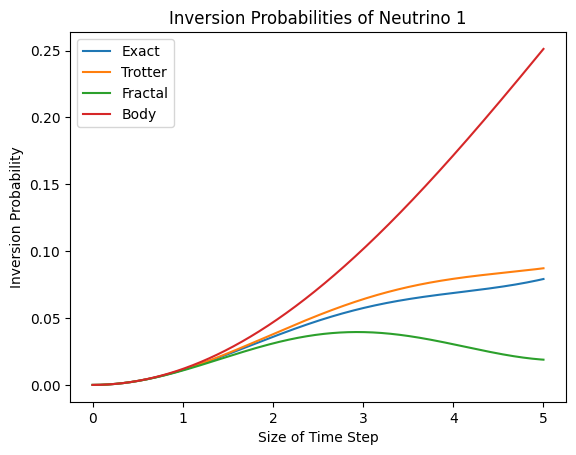

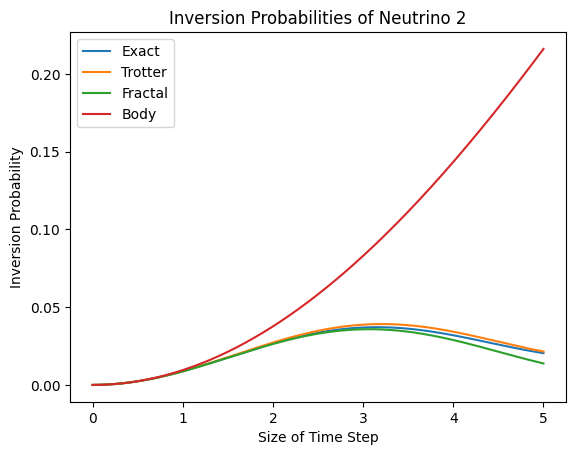

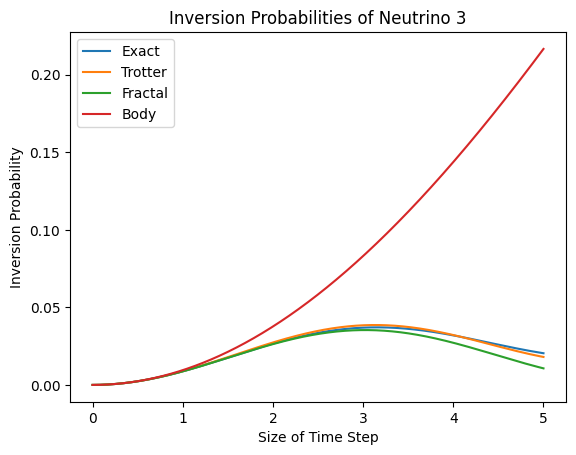

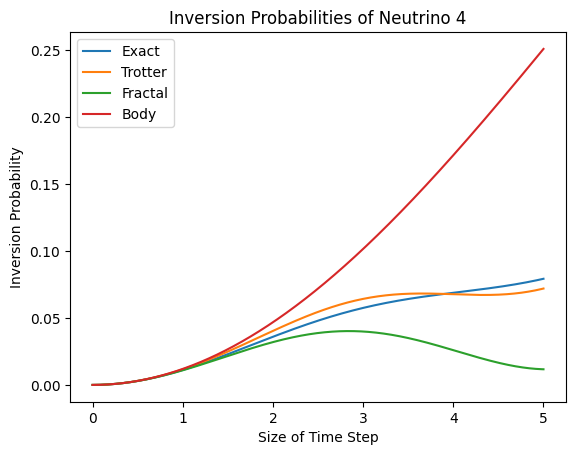

In [140]:
"""
# Plot the probability curve for each qubit on the same graph
for i in range(N):
    plt.plot(ts, exact_probabilities[i], label=f'Exact')
    plt.plot(ts, trotter_probabilities[i], label=f'Trotter')
    plt.plot(ts, fractal_probabilities[i], label=f'Fractal')
    plt.plot(ts, body_probabilities[i], label=f'Body')
    

    plt.xlabel('Size of Time Step')
    plt.ylabel('Inversion Probability')
    plt.title(f'Inversion Probabilities of Neutrino {i+1}')
    plt.legend()
    plt.show()
"""

In [57]:
def test_exact(t, a,b,c):
    x, y,z = qp.sigmax(), qp.sigmay(), qp.sigmaz()
    H = a*x+b*y+c*z
    U = qp.Qobj(sp.linalg.expm(-1j*t*H) , dims = x.dims)
    return U

def test_trotter(t, a,b,c):
    x, y, z = qp.sigmax(), qp.sigmay(), qp.sigmaz()
    Ua = qp.Qobj(sp.linalg.expm(-1j*t*a*x) , dims = x.dims)
    Ub = qp.Qobj(sp.linalg.expm(-1j*t*b*y) , dims = y.dims)
    Uc = qp.Qobj(sp.linalg.expm(-1j*t*c*z) , dims = z.dims)
    return Uc * Ub * Ua

def test_fractal(t,a,b,c):
    x, y, z  = qp.sigmax(), qp.sigmay(), qp.sigmaz()
    Ua = qp.Qobj(sp.linalg.expm(-1j*t*a*x) , dims = x.dims)
    Ub = qp.Qobj(sp.linalg.expm(-0.5j*t*b*y) , dims = y.dims)
    Uc = qp.Qobj(sp.linalg.expm(-0.25j*t*c*z) , dims = z.dims)
    return Uc * Ub * Uc * Ua * Uc * Ub * Uc

In [137]:
initial_flavors = [1]
N = 1
a = 1
b = 2
c = 2
ts = np.linspace(0, 0.4, steps)
test_exact_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    test_exact_probabilities[:,idx] = inversion_probability(initial_flavors, test_exact(t, a, b, c))

test_trotter_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    test_trotter_probabilities[:,idx] = inversion_probability(initial_flavors, test_trotter(t, a, b, c))

test_fractal_probabilities = np.zeros((N,steps))
for idx, t in enumerate(ts):
    test_fractal_probabilities[:,idx] = inversion_probability(initial_flavors, test_fractal(t, a, b, c))

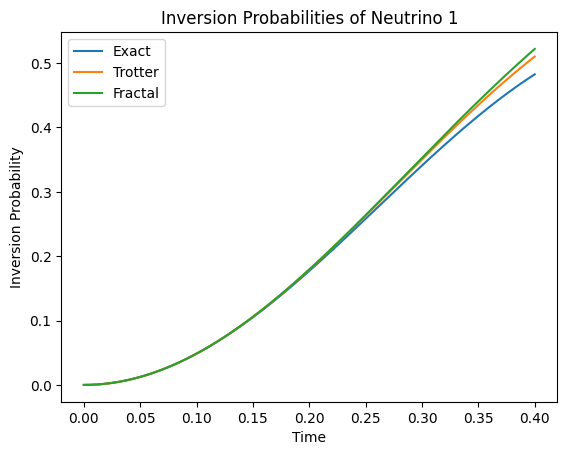

Trotter Average Absolute Error: 0.00590608525838638
Fractal Average Absolute Error: 0.007748550534462332


In [138]:
# Plot the probability curve for each qubit on the same graph
for i in range(N):
    plt.plot(ts, test_exact_probabilities[i], label=f'Exact')
    plt.plot(ts, test_trotter_probabilities[i], label=f'Trotter')
    plt.plot(ts, test_fractal_probabilities[i], label=f'Fractal')

    plt.xlabel('Time')
    plt.ylabel('Inversion Probability')
    plt.title(f'Inversion Probabilities of Neutrino {i+1}')
    plt.legend()
    plt.show()
    trotter_error = np.mean(np.abs(test_exact_probabilities[i] - test_trotter_probabilities[i]))
    fractal_error = np.mean(np.abs(test_exact_probabilities[i] - test_fractal_probabilities[i]))
    print(f'Trotter Average Absolute Error: {trotter_error}')
    print(f'Fractal Average Absolute Error: {fractal_error}')